# Classification


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import os
import random

# Remove randomness
SEED = 42

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = ""   # disable GPU → CPU only

2025-11-26 14:25:33.819277: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Reading the dataset
df = pd.read_csv('./data/ObesityDataSet_raw_and_data_sinthetic.csv')
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


## EDA and preprocessing

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [4]:
df.isnull().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [5]:
df.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [6]:
df['NObeyesdad'].value_counts()

NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64

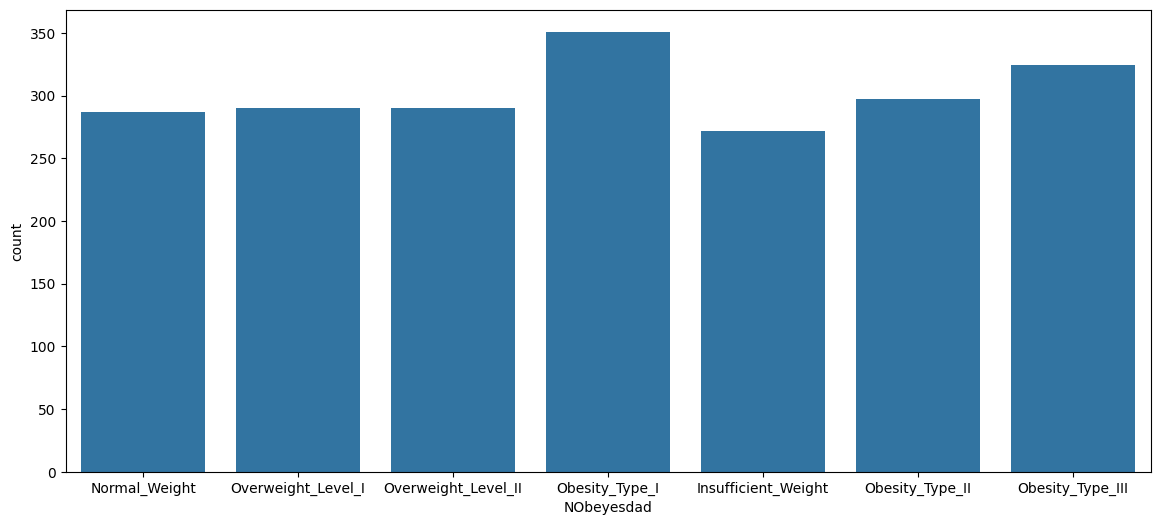

In [7]:
plt.figure(figsize=(14,6))
sns.countplot(x='NObeyesdad', data=df)
plt.show()

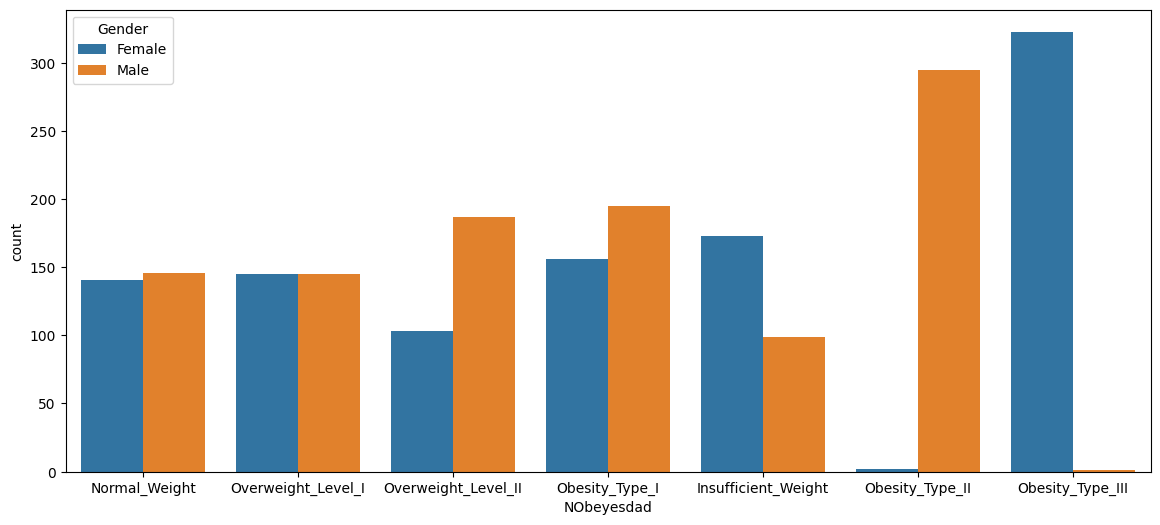

In [8]:
plt.figure(figsize=(14,6))
sns.countplot(x='NObeyesdad', hue="Gender", data=df)
plt.show()

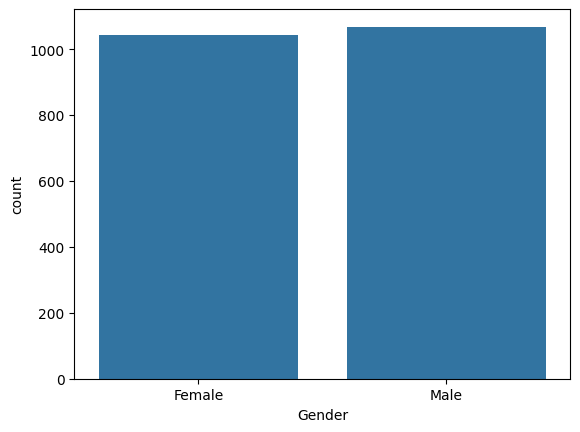

In [9]:
sns.countplot(x='Gender', data=df)
plt.show()

In [10]:
df_objects = df.select_dtypes(include=['object']) 
df_objects.drop("NObeyesdad", axis=1, inplace=True)
df_objects

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS
0,Female,yes,no,Sometimes,no,no,no,Public_Transportation
1,Female,yes,no,Sometimes,yes,yes,Sometimes,Public_Transportation
2,Male,yes,no,Sometimes,no,no,Frequently,Public_Transportation
3,Male,no,no,Sometimes,no,no,Frequently,Walking
4,Male,no,no,Sometimes,no,no,Sometimes,Public_Transportation
...,...,...,...,...,...,...,...,...
2106,Female,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation
2107,Female,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation
2108,Female,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation
2109,Female,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation


In [11]:
df_objects.nunique()

Gender                            2
family_history_with_overweight    2
FAVC                              2
CAEC                              4
SMOKE                             2
SCC                               2
CALC                              4
MTRANS                            5
dtype: int64

In [12]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder

new_df = df.copy()

binary_cols = ["Gender", "family_history_with_overweight", "FAVC", "SMOKE", "Gender", "SCC"]

categorical_cols = ["CAEC", "CALC", "MTRANS"]

# Applying Ordinal encoder
ord_enc = OrdinalEncoder()
new_df[binary_cols] = ord_enc.fit_transform(new_df[binary_cols])

# Applying one-hot encoding
hot_enc = OneHotEncoder()
encoded_data = hot_enc.fit_transform(new_df[categorical_cols])
new_df[hot_enc.get_feature_names_out(categorical_cols)] = encoded_data.toarray()
new_df.drop(columns=categorical_cols, inplace=True)

# Applying Label Encoder
encoder = LabelEncoder()
new_df["NObeyesdad"] = encoder.fit_transform(df["NObeyesdad"])
new_df.head()


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,SMOKE,CH2O,...,CAEC_no,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0.0,21.0,1.62,64.0,1.0,0.0,2.0,3.0,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,21.0,1.52,56.0,1.0,0.0,3.0,3.0,1.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,23.0,1.80,77.0,1.0,0.0,2.0,3.0,0.0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,27.0,1.80,87.0,0.0,0.0,3.0,3.0,0.0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,22.0,1.78,89.8,0.0,0.0,2.0,1.0,0.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [13]:
int_to_label = {index: label for index, label in enumerate(encoder.classes_)}
int_to_label

{0: 'Insufficient_Weight',
 1: 'Normal_Weight',
 2: 'Obesity_Type_I',
 3: 'Obesity_Type_II',
 4: 'Obesity_Type_III',
 5: 'Overweight_Level_I',
 6: 'Overweight_Level_II'}

### Train Test split

The dataset will be split into train of 80% and Test of 20%.

In [14]:
from sklearn.model_selection import train_test_split
X, Y = new_df.drop("NObeyesdad", axis=1), new_df["NObeyesdad"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y, random_state=10)
print(len(X_train), len(X_test))

1688 423


### Handling Gender Imbalance

In [15]:
# Combine the training df with the target df
train_df = pd.concat([X_train, y_train], axis=1) 
# Create a composite dataframe
train_df["composite_target"] = train_df['NObeyesdad'].astype(str) + "-" + train_df['Gender'].astype(str) 
train_df.head(10)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,SMOKE,CH2O,...,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,NObeyesdad,composite_target
1940,0.0,26.000000,1.622468,110.400847,1.0,1.0,3.000000,3.000000,0.0,2.695094,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4,4-0.0
718,0.0,21.310907,1.720640,50.000000,1.0,1.0,2.919584,3.697831,0.0,1.147121,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0-0.0
2103,0.0,21.016849,1.724268,133.033523,1.0,1.0,3.000000,3.000000,0.0,1.650612,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4,4-0.0
1691,1.0,30.722801,1.779325,120.751656,1.0,1.0,2.519592,3.000000,0.0,2.229145,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3,3-1.0
1865,0.0,21.633056,1.754174,133.783955,1.0,1.0,3.000000,3.000000,0.0,1.945950,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4,4-0.0
913,1.0,21.000000,1.610209,68.865008,0.0,1.0,1.910176,2.938135,0.0,2.943097,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5,5-1.0
1980,0.0,25.795187,1.669039,104.593929,1.0,1.0,3.000000,3.000000,0.0,1.554925,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4,4-0.0
2053,0.0,21.232659,1.719913,131.567481,1.0,1.0,3.000000,3.000000,0.0,1.651462,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4,4-0.0
467,1.0,22.000000,1.740000,75.000000,1.0,1.0,3.000000,3.000000,0.0,1.000000,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1,1-1.0
644,1.0,17.580627,1.770324,55.695253,1.0,1.0,2.000000,4.000000,0.0,2.369627,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0-1.0


In [16]:
# check for a class that has only one sample while applying SMOTE
train_df.groupby(['composite_target']).size()

composite_target
0-0.0    144
0-1.0     74
1-0.0    111
1-1.0    118
2-0.0    120
2-1.0    161
3-0.0      2
3-1.0    235
4-0.0    258
4-1.0      1
5-0.0    119
5-1.0    113
6-0.0     82
6-1.0    150
dtype: int64

In [17]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE

X = train_df.drop(['composite_target'], axis=1)
y = train_df['composite_target']

oversample = Pipeline(steps=[
    ('random', RandomOverSampler(random_state=10)),   # handles 1-sample groups
    ('smote', SMOTE(k_neighbors=1, random_state=10))    # handles groups with >=2 samples
])

X_resampled, y_resampled = oversample.fit_resample(X, y)

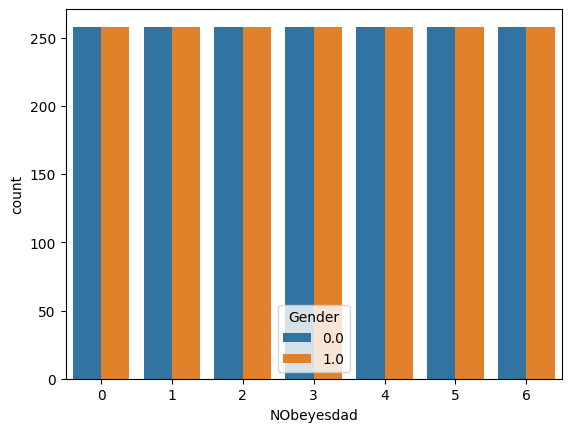

In [18]:
sns.countplot(hue=X_resampled["Gender"], x=X_resampled["NObeyesdad"])
plt.show()

In [19]:
y_train = X_resampled["NObeyesdad"]
X_resampled.drop(["NObeyesdad"], inplace=True, axis=1)

In [20]:
X_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3612 entries, 0 to 3611
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          3612 non-null   float64
 1   Age                             3612 non-null   float64
 2   Height                          3612 non-null   float64
 3   Weight                          3612 non-null   float64
 4   family_history_with_overweight  3612 non-null   float64
 5   FAVC                            3612 non-null   float64
 6   FCVC                            3612 non-null   float64
 7   NCP                             3612 non-null   float64
 8   SMOKE                           3612 non-null   float64
 9   CH2O                            3612 non-null   float64
 10  SCC                             3612 non-null   float64
 11  FAF                             3612 non-null   float64
 12  TUE                             36

## Model Building

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_resampled)
X_test = scaler.fit_transform(X_test)
X_train

array([[-1.        ,  0.41381103, -0.79385451, ..., -0.06010087,
         0.55987011, -0.17132744],
       [-1.        , -0.34364721,  0.16841183, ..., -0.06010087,
         0.55987011, -0.17132744],
       [-1.        , -0.39114822,  0.20397291, ..., -0.06010087,
         0.55987011, -0.17132744],
       ...,
       [ 1.        ,  1.90271809,  1.17337499, ..., -0.06010087,
        -1.78612856, -0.17132744],
       [ 1.        ,  1.29039899,  1.42346897, ..., -0.06010087,
        -1.78612856, -0.17132744],
       [ 1.        , -0.39599673, -0.25759579, ..., -0.06010087,
         0.55987011, -0.17132744]])

### Building Random Forest Classifier

In [22]:
from sklearn.ensemble import RandomForestClassifier

rfc_model = RandomForestClassifier(random_state=48)
rfc_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [23]:
# Make predictions
y_pred = rfc_model.predict(X_test)
y_pred

array([3, 6, 1, 6, 2, 6, 2, 6, 2, 6, 1, 6, 6, 0, 3, 0, 4, 4, 2, 6, 5, 2,
       5, 0, 6, 6, 5, 0, 5, 3, 0, 3, 0, 4, 4, 5, 5, 1, 6, 5, 2, 4, 5, 4,
       3, 2, 3, 2, 4, 4, 3, 0, 2, 4, 3, 1, 3, 4, 5, 3, 4, 2, 1, 0, 2, 6,
       3, 2, 6, 1, 0, 0, 6, 6, 1, 3, 5, 4, 0, 5, 1, 0, 0, 1, 5, 4, 4, 0,
       4, 1, 4, 6, 3, 4, 2, 6, 6, 1, 3, 0, 1, 3, 3, 0, 5, 4, 4, 2, 0, 4,
       3, 0, 1, 6, 0, 3, 0, 3, 6, 6, 5, 0, 3, 2, 0, 6, 1, 6, 2, 1, 0, 4,
       0, 0, 2, 4, 3, 0, 2, 2, 3, 4, 0, 6, 1, 0, 6, 3, 0, 0, 1, 5, 2, 0,
       1, 1, 1, 2, 4, 5, 4, 5, 2, 2, 0, 5, 4, 4, 2, 3, 1, 3, 2, 2, 6, 2,
       6, 5, 0, 0, 5, 1, 2, 2, 0, 0, 1, 4, 2, 6, 5, 4, 4, 5, 5, 4, 0, 0,
       5, 1, 6, 5, 2, 1, 0, 6, 6, 5, 3, 5, 1, 4, 4, 3, 6, 3, 2, 2, 0, 6,
       1, 1, 0, 1, 5, 2, 2, 3, 5, 4, 6, 3, 2, 4, 2, 2, 6, 2, 6, 4, 3, 4,
       5, 0, 0, 3, 3, 4, 5, 6, 5, 3, 4, 5, 3, 5, 3, 5, 3, 2, 2, 4, 4, 2,
       0, 2, 1, 4, 4, 6, 3, 2, 6, 4, 2, 3, 4, 5, 0, 6, 1, 3, 5, 5, 1, 0,
       2, 2, 5, 5, 4, 0, 0, 6, 2, 1, 1, 3, 0, 1, 3,

In [24]:
cr = classification_report(y_test, y_pred, target_names=encoder.classes_)
accuracy = rfc_model.score(X_test, y_test)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(cr)

Accuracy: 0.9030732860520094
Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.78      0.94      0.86        54
      Normal_Weight       0.80      0.69      0.74        58
     Obesity_Type_I       0.94      0.91      0.93        70
    Obesity_Type_II       0.97      1.00      0.98        60
   Obesity_Type_III       1.00      1.00      1.00        65
 Overweight_Level_I       0.91      0.90      0.90        58
Overweight_Level_II       0.89      0.86      0.88        58

           accuracy                           0.90       423
          macro avg       0.90      0.90      0.90       423
       weighted avg       0.90      0.90      0.90       423



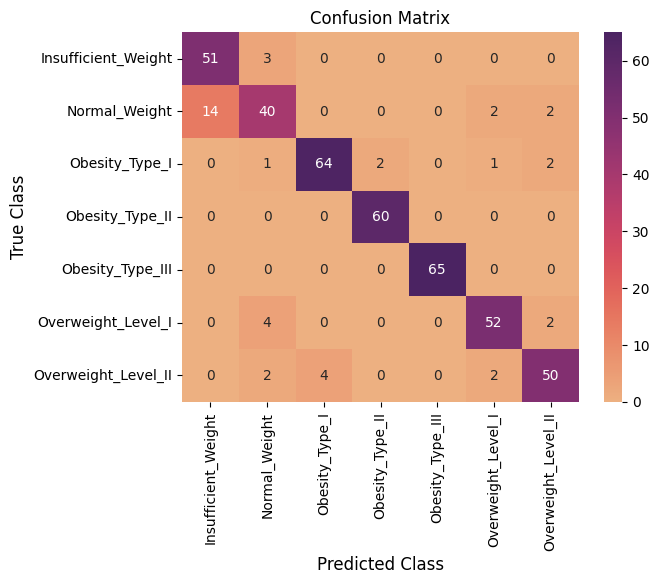

In [25]:
cm_rf = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm_rf, cmap='flare',annot=True, fmt='d', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted Class",fontsize=12)
plt.ylabel("True Class",fontsize=12)
plt.title("Confusion Matrix",fontsize=12)
plt.show()

### Building the Neutral Network

In [26]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(128,activation='relu',input_shape=(X_train.shape[1],)))
model.add(tf.keras.layers.Dense(64,activation='relu'))
model.add(tf.keras.layers.Dense(7,activation='softmax'))

/Users/macbook/salford-ml/AI-ML-PROJECTS/mldm/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics= ['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,167 (47.53 KB)

 Trainable params: 12,167 (47.53 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history = model.fit(X_train, np.asarray(y_train), batch_size = 32, epochs= 20, verbose=2, validation_split=0.2)

Epoch 1/20
91/91 - 2s - 27ms/step - accuracy: 0.5929 - loss: 1.2518 - val_accuracy: 0.3043 - val_loss: 1.3842
Epoch 2/20
91/91 - 0s - 3ms/step - accuracy: 0.7947 - loss: 0.6168 - val_accuracy: 0.5823 - val_loss: 0.9844
Epoch 3/20
91/91 - 0s - 4ms/step - accuracy: 0.8633 - loss: 0.4273 - val_accuracy: 0.7275 - val_loss: 0.7546
Epoch 4/20
91/91 - 0s - 4ms/step - accuracy: 0.9058 - loss: 0.3123 - val_accuracy: 0.8050 - val_loss: 0.5917
Epoch 5/20
91/91 - 1s - 7ms/step - accuracy: 0.9398 - loss: 0.2351 - val_accuracy: 0.8686 - val_loss: 0.4695
Epoch 6/20
91/91 - 1s - 9ms/step - accuracy: 0.9567 - loss: 0.1822 - val_accuracy: 0.9032 - val_loss: 0.3772
Epoch 7/20
91/91 - 0s - 4ms/step - accuracy: 0.9668 - loss: 0.1435 - val_accuracy: 0.9322 - val_loss: 0.3022
Epoch 8/20
91/91 - 0s - 5ms/step - accuracy: 0.9733 - loss: 0.1149 - val_accuracy: 0.9502 - val_loss: 0.2426
Epoch 9/20
91/91 - 0s - 5ms/step - accuracy: 0.9813 - loss: 0.0929 - val_accuracy: 0.9585 - val_loss: 0.1959
Epoch 10/20
91/91 

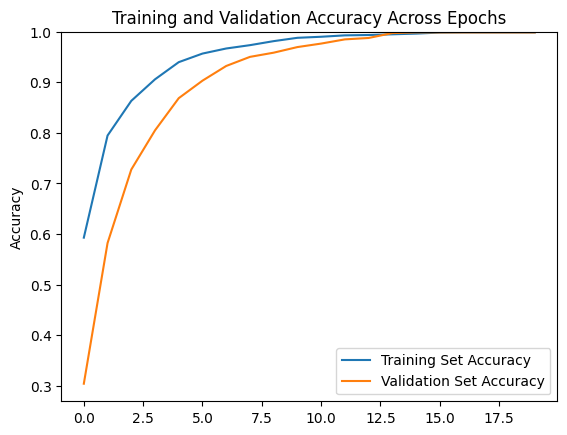

In [29]:
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
plt.plot(accuracy, label='Training Set Accuracy')
plt.plot(validation_accuracy, label='Validation Set Accuracy')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy Across Epochs')
plt.legend()

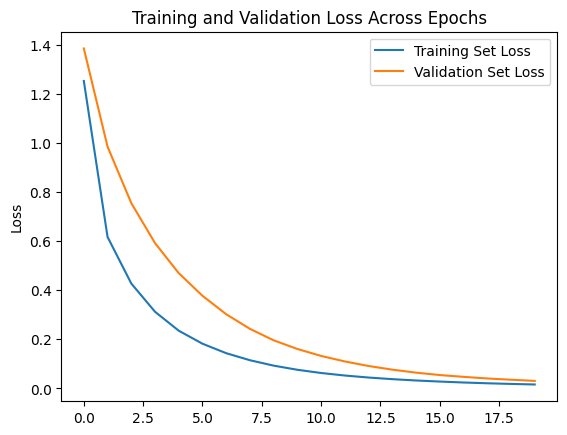

In [30]:
loss = history.history['loss']
validation_loss = history.history['val_loss']
plt.plot(loss, label='Training Set Loss')
plt.plot(validation_loss, label='Validation Set Loss')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Epochs')
plt.legend()


In [31]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1)
y_pred

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


array([3, 6, 6, 6, 2, 6, 2, 6, 5, 5, 1, 6, 6, 0, 3, 0, 4, 4, 2, 6, 5, 2,
       5, 0, 6, 6, 5, 0, 5, 3, 1, 3, 0, 4, 4, 5, 1, 1, 6, 5, 2, 4, 5, 4,
       3, 6, 3, 2, 4, 4, 3, 0, 3, 4, 3, 1, 3, 4, 5, 3, 4, 2, 5, 0, 2, 6,
       3, 2, 6, 1, 0, 0, 6, 6, 1, 3, 5, 4, 0, 6, 1, 0, 0, 1, 1, 4, 4, 0,
       4, 5, 4, 6, 3, 4, 2, 6, 6, 1, 3, 0, 0, 3, 3, 0, 5, 4, 4, 2, 0, 4,
       3, 1, 1, 6, 0, 3, 0, 3, 6, 5, 5, 0, 3, 2, 0, 6, 2, 6, 2, 6, 0, 4,
       0, 1, 2, 4, 3, 0, 2, 6, 2, 4, 0, 6, 5, 0, 6, 3, 0, 0, 1, 5, 2, 1,
       1, 1, 1, 2, 4, 5, 4, 1, 2, 2, 0, 5, 4, 4, 2, 3, 1, 3, 2, 2, 1, 2,
       6, 5, 0, 0, 5, 1, 2, 2, 0, 1, 1, 4, 2, 6, 5, 4, 4, 5, 5, 4, 0, 0,
       5, 0, 6, 5, 2, 1, 0, 6, 6, 5, 3, 5, 1, 4, 4, 3, 6, 3, 2, 2, 0, 1,
       1, 1, 0, 1, 5, 2, 2, 3, 1, 4, 6, 3, 2, 4, 2, 2, 6, 2, 6, 4, 3, 4,
       5, 0, 0, 3, 3, 4, 5, 6, 5, 3, 4, 1, 3, 5, 3, 5, 3, 3, 2, 4, 4, 2,
       0, 2, 0, 4, 4, 6, 3, 2, 6, 4, 2, 3, 4, 5, 0, 6, 0, 3, 5, 5, 1, 0,
       2, 2, 5, 5, 4, 0, 0, 6, 2, 1, 5, 3, 0, 1, 3,

In [32]:
cr = classification_report(y_test, y_pred, target_names=encoder.classes_)
print("Classification Report:")
print(cr)

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.81      0.96      0.88        54
      Normal_Weight       0.80      0.76      0.78        58
     Obesity_Type_I       0.98      0.91      0.95        70
    Obesity_Type_II       0.94      1.00      0.97        60
   Obesity_Type_III       1.00      1.00      1.00        65
 Overweight_Level_I       0.93      0.88      0.90        58
Overweight_Level_II       0.95      0.90      0.92        58

           accuracy                           0.92       423
          macro avg       0.92      0.92      0.91       423
       weighted avg       0.92      0.92      0.92       423



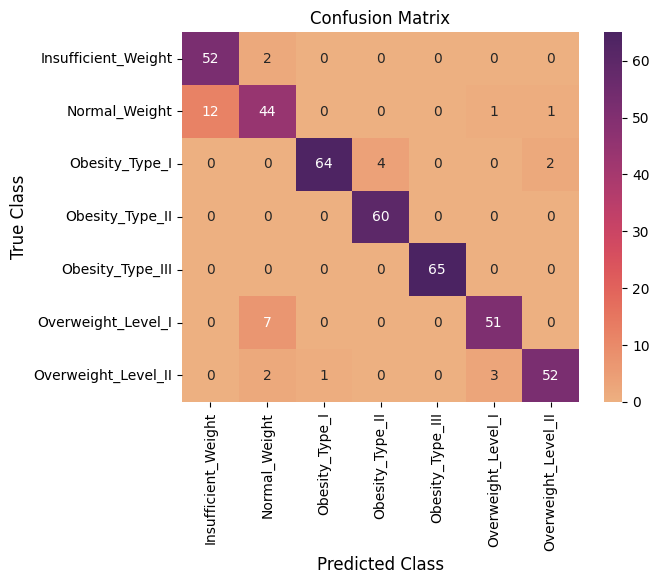

In [33]:
cm_nn = confusion_matrix(y_test,y_pred)
ax = sns.heatmap(cm_nn, cmap='flare',annot=True, fmt='d', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted Class",fontsize=12)
plt.ylabel("True Class",fontsize=12)
plt.title("Confusion Matrix",fontsize=12)
plt.show()

In [34]:
print(X_test.shape)
print(y_test.shape)

(423, 26)
(423,)


In [35]:
### Confusion Matrix

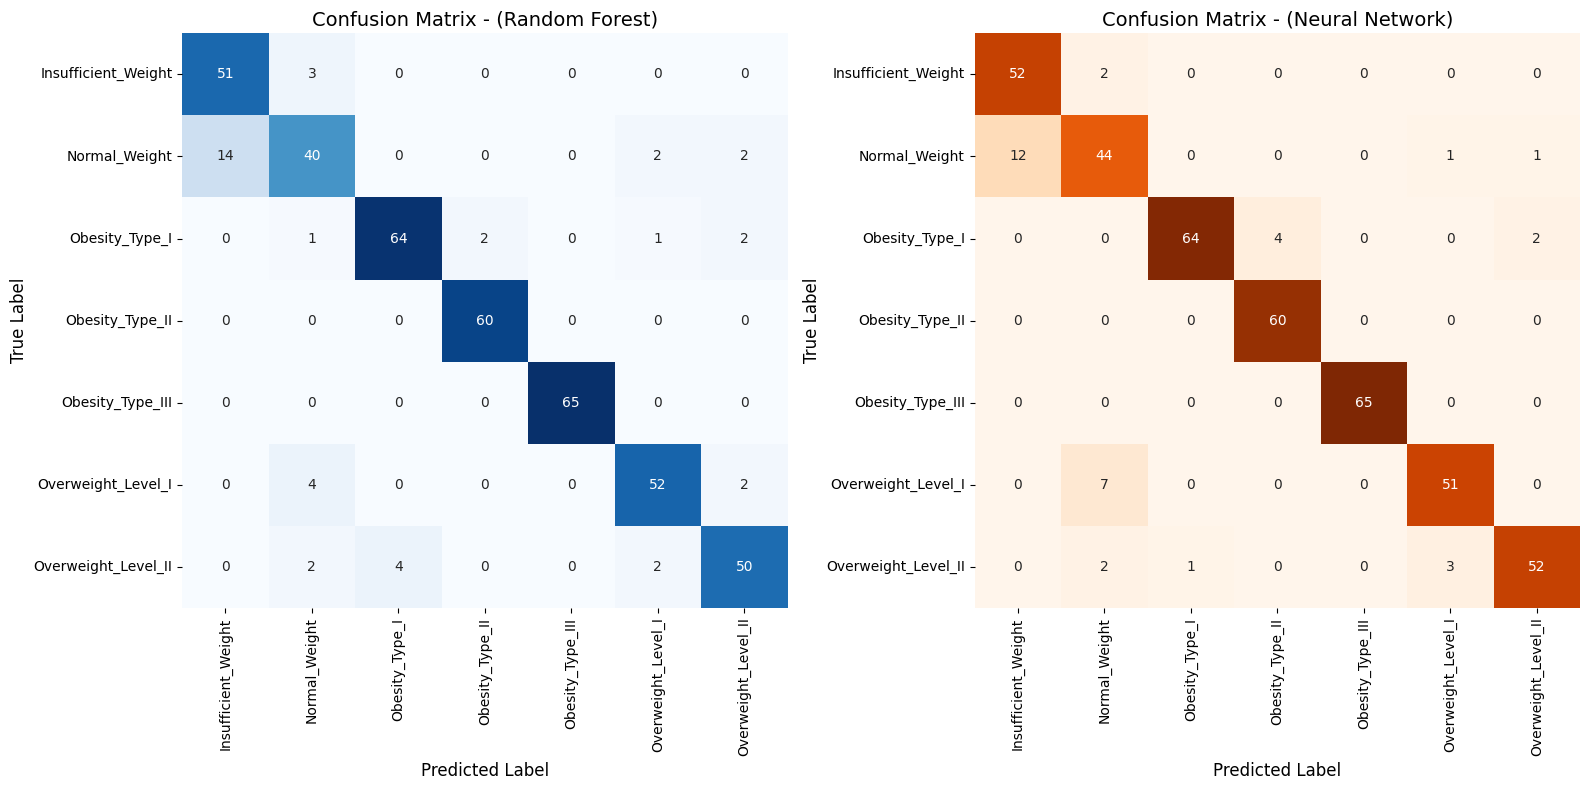

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
class_names = encoder.classes_

# Plot Confusion Matrix Random Forest
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0],
            xticklabels=class_names, yticklabels=class_names)
axes[0].set_title('Confusion Matrix - (Random Forest)', fontsize=14)
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)

# Plot Confusion Matrix Neural Network
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Oranges', cbar=False, ax=axes[1],
            xticklabels=class_names, yticklabels=class_names)
axes[1].set_title('Confusion Matrix - (Neural Network)', fontsize=14)
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)

plt.tight_layout()